In [1]:
%matplotlib widget
from bmcs_cross_section.api import MKappa, TShape, MKappaParamsStudy, EC2, ReinfLayer, IShape, CustomShape, EC2ConcreteMatMod, EC2PlateauConcreteMatMod
from bmcs_beam.api import FourPBSystem, BoundaryConditions, BoundaryConfig, DeflectionProfile, BeamDesign, LoadDeflectionParamsStudy, SLSParamStudy, BeamSLSCurve
import numpy as np
import bmcs_utils.api as bu
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Concrete C3-HF2-165-4
E_cm_C3 = 42720
f_cm_C3 = 95
fctm_sp = 5.0
fctm_fl = 12.51

In [3]:
# solidian GRID Q95-CCE-38-E5 (according to performed tensile tests)
f_t_mat = 3823.9
E_f_mat = 247468.92

In [4]:
def get_dp(f_cm = f_cm_C3, E_cm = E_cm_C3, fctm_fl=None,
           setup='4pb', L=2000, L_F=None,
           high_kappa = 0.00018, concrete_law='EC2',
           B=200, H=150, A = None,
           reinf = 'carbon',
           E_nm=None, f_t=None, z=None,
           grid_layers_n=1, grid_layers_spacing=10, grid_layers_area=[]):
    
    mc = MKappa(low_kappa = 0, high_kappa = high_kappa, n_kappa=200)
    
    mc.cs_design.matrix=concrete_law
    
    f_ck = EC2.get_f_ck_from_f_cm(f_cm)
    if fctm_fl is None:
        fctm_fl = EC2.get_f_ctm_fl(f_ck, H)
    if concrete_law == 'EC2 with plateau' or concrete_law == 'EC2':
        mc.cs_design.matrix_.trait_set(f_cm = f_cm)
    elif concrete_law == 'piecewise linear':
        mc.cs_design.matrix_.trait_set(
            eps_cy=EC2.get_eps_c3(f_ck),
            eps_cu=EC2.get_eps_cu3(f_ck),
        )
    
    mc.cs_design.matrix_.trait_set(E_cc=E_cm, 
                                   E_ct=E_cm, 
                                   eps_cr = fctm_fl/E_cm, 
                                   eps_tu = fctm_fl/E_cm,)

    mc.cross_section_shape_.B = B
    mc.cross_section_shape_.H = H

    # Carbon properties
    E_nm=E_f_mat if E_nm is None else E_nm
    f_t=f_t_mat if f_t is None else f_t
    spacing = 38
    rov_num = int(B/spacing) + 1
    rov_cs_area = 3.62
    if A is None:
        A = rov_num * rov_cs_area
    if z is None:
        z = 10
        
    d = H - z
    
    if reinf == 'carbon':
        if grid_layers_n == 1:
            bl1 = ReinfLayer(name='grid', z=z, A=A, matmod='carbon')
            bl1.matmod_.trait_set(E=E_nm, f_t=f_t, factor = 1.)
            mc.cross_section_layout.add_layer(bl1)
        else:
            for i in range(grid_layers_n):
                if grid_layers_area:
                    bl1 = ReinfLayer(name='grid', z=z + i*grid_layers_spacing, A=grid_layers_area[i], matmod='carbon')
                else:
                    bl1 = ReinfLayer(name='grid', z=z + i*grid_layers_spacing, A=A, matmod='carbon')
                bl1.matmod_.trait_set(E=E_nm, f_t=f_t, factor = 1.)
                mc.cross_section_layout.add_layer(bl1)
            A = grid_layers_n * A
    else:
        bl1 = ReinfLayer(name='rebars', z=z, A=A, matmod='steel')
        mc.cross_section_layout.add_layer(bl1)

    rho = A/(B*d)
    print('A=', A)
    print(r'rho =', round(rho * 100, 2), r'%')
    # mechanical reinforcement ratio
#     w_m = A * f_t / (B * H * f_cm)
#     print('w_m:', w_m)

    dp = DeflectionProfile(mc=mc)
    
    if setup == '4pb':
        dp.beam_design.system = '4pb'
        if L_F is not None:
            print('L_F assigned!')
            dp.beam_design.system_.L_F = L_F
    elif setup == '3pb':
        dp.beam_design.system = '3pb'
    elif setup == 'dist':
        dp.beam_design.system = 'simple_beam_dist_load'
        
    dp.beam_design.system_.L = L
    
    print('l/d =', dp.beam_design.system_.L/d)
    
    return dp

In [8]:
def get_exp_data(test_num=1):
    skiprows = 3
    delimiter=';'
    decimal=','
    file_path = './results/T' + str(test_num) + '.csv'
    headers_array = list(np.array(pd.read_csv(file_path, delimiter=delimiter, decimal=decimal, nrows=1, header=None))[0])
    
    time_idx = 0
    force_idx = headers_array.index('Kraft')
    weg_idx = headers_array.index('Weg')
    IWA_M_hinten_idx = headers_array.index('IWA_M_hinten')
    IWA_M_vorne_idx = headers_array.index('IWA_M_vorne')
    DMS_idx = headers_array.index('DMS-1')
    
    data = np.array(pd.read_csv(file_path, delimiter=delimiter, decimal=decimal, skiprows=skiprows))
    time = data[:, 0]
    force = -data[:, force_idx]
    dms = -data[:, DMS_idx]
    weg = -data[:, weg_idx]
    hinten_vorne = - data[:, (IWA_M_hinten_idx, IWA_M_vorne_idx)]
    avg_hinten_vorne = (hinten_vorne[:, 0] + hinten_vorne[:, 1])/2
    
    return time, force, weg, avg_hinten_vorne, dms, hinten_vorne

def get_exp_fw(test_num=1):
    _, force, _, avg_hinten_vorne, _ = get_exp_data(test_num = test_num)
    return force, avg_hinten_vorne

In [47]:
get_dp().interact()

A= 150.60000000000002
rho = 0.55 %
l/d = 14.705882352941176
V_Rm_c = 35.9 kN, Shear failure by F_tot_max = 71.8 kN


## Grid data

In [9]:
grid_data = dict(high_kappa =0.0003, B=300, H=100, concrete_law = 'EC2', L=1800)
dp = get_dp(**grid_data)
# sls = BeamSLSCurve(n_i = 12, dp=dp)
dp.interact()
# sls.run()
# sls.interact()

A= 28.96
rho = 0.11 %
l/d = 20.0
V_Rm_c = 20.69 kN, Shear failure by F_tot_max = 41.38 kN


In [6]:
# sls.plot_F_u()
sls.plot_F_u(bending_shear_diff = True)
# sls.plot_F_u(load='shear')


# Achse x: Bewehrungsgrad rho [%]
# Achse y: Biegeschlankheit l/d [-]

NameError: name 'sls' is not defined

## Grid 1 layer, 3PB

In [11]:
dp = get_dp(**grid_data, setup='3pb', fctm_fl=5)
dp.interact()

A= 28.96
rho = 0.11 %
l/d = 20.0


### T8_3PB_C_1
It's giving very good results (especially in the begining of the curve where the first crack appears) with the new softening tensile law with high resolution for L-D and kappa

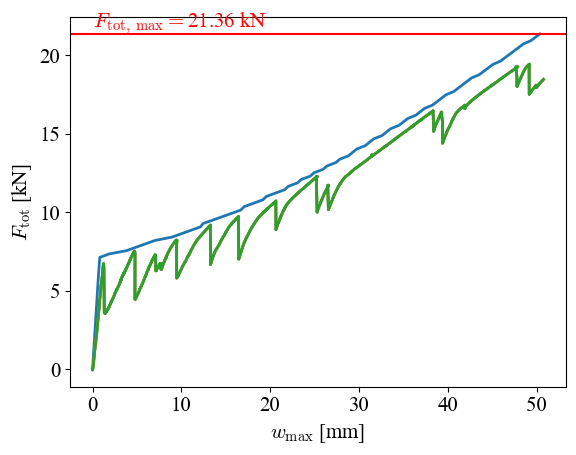

In [14]:
# Importing exp data
_, force, _, _, _ , hinten_vorne= get_exp_data(test_num = 8)

deflection = hinten_vorne[:, 1]

# Adding exp data to dp object
dp.add_fw_exp(force, deflection)

# Plotting load-deflection
fig, ax = plt.subplots()
dp.plot_fw_with_fmax(ax)
# fig.savefig('T1_4PB_C_1_load_deflection.pdf')
fig

## Grid 1 layer, 4pb loading

In [51]:
dp = get_dp(high_kappa =0.0003, B=303, H=99, carbon_type = 'grid', concrete_law = 'EC2', L=1800, 
            setup='4pb', f_t=3800, E_nm=245000, fctm_fl=5.2, E_cm=45208.51, f_cm=97.58)
dp.interact()

A= 28.96
rho = 0.11 %
l/d = 20.224719101123597
V_Rm_c = 20.67 kN, Shear failure by F_tot_max = 41.34 kN


### T1_4PB_C_1

V_Rm_c = 20.67 kN, Shear failure by F_tot_max = 41.34 kN


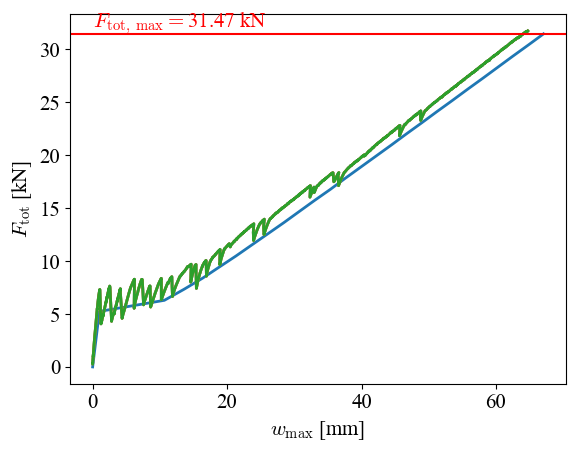

In [54]:
# Importing exp data
force, deflection = get_exp_fw(1)

# Adding exp data to dp object
dp.add_fw_exp(force, deflection)

# Plotting load-deflection
fig, ax = plt.subplots()
dp.plot_fw_with_fmax(ax)
# fig.savefig('T1_4PB_C_1_load_deflection.pdf')
fig

### T2_4PB_C_1

In [55]:
beton_stauchung_max = -1525*1e-6
beton_stauchung_max

-0.0015249999999999999

In [56]:
B_1_M_1 = dict(f_cm = 97.58, E_cm = 45208.51, fctm_fl=0.9*5.02)
dp = get_dp(**grid_data, setup='4pb', **B_1_M_1)
dp.interact()

A= 28.96
rho = 0.11 %
l/d = 20.0
V_Rm_c = 20.37 kN, Shear failure by F_tot_max = 40.74 kN


## Grid 1.5 layers

In [57]:
dp = get_dp(**grid_data, grid_layers_n=2, grid_layers_spacing=10, setup='4pb')

dp.mc.cross_section_layout.items[1].z = 20
dp.mc.cross_section_layout.items[1].A = 4 * 3.62 # 0.5 layer

dp.interact()

A= 57.92
rho = 0.21 %
l/d = 20.0
V_Rm_c = 20.74 kN, Shear failure by F_tot_max = 41.48 kN


## Grid 3 layers, 4pb (shear failure!)

In [58]:
4130*1e-6

0.00413

In [59]:
# dp = get_dp(**grid_data, grid_layers_n=3, grid_layers_spacing=10, setup='4pb')
dp = get_dp(high_kappa =0.0003, B=200, H=80, carbon_type = 'grid', concrete_law = 'EC2', L=1800, grid_layers_n=3, grid_layers_spacing=10, setup='4pb')

dp.mc.cross_section_layout.items[1].z = 15
dp.mc.cross_section_layout.items[2].z = 20
# dp.mc.cross_section_layout.items[1].A = 4 * 3.62 # 0.5 layer

# NOTE: Edit area of each layer to be 5*3.62 = 18.1 mm^2, because 6 layers fit but will not have concrete cover from the sides

dp.interact()

A= 65.16
rho = 0.47 %
l/d = 25.714285714285715
V_Rm_c = 10.67 kN, Shear failure by F_tot_max = 21.34 kN


## Grid 0.5 layer + 2 steel rebars, 4pb loading

In [60]:
dp = get_dp(**grid_data, setup='4pb', z=20, A=4*3.62)

bl1 = ReinfLayer(name='steel', z=14, A=2*np.pi * (4**2), matmod='steel')
dp.mc.cross_section_layout.add_layer(bl1)

dp.interact()

A= 14.48
rho = 0.06 %
l/d = 22.5
V_Rm_c = 14.33 kN, Shear failure by F_tot_max = 28.66 kN


## 4 Steel rebars, 4pb

In [61]:
dp = get_dp(high_kappa =0.0003, B=300, H=100, setup='4pb', reinf = 'steel', concrete_law = 'EC2', L=1800, A=4*np.pi * (4**2), z=14)
dp.interact()

A= 201.06192982974676
rho = 0.78 %
l/d = 20.930232558139537
